In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

from dataset.dataset import SaladsDataset
from main import discover_dk_process
from Config import Config
import json
import pickle as pkl
import pm4py

In [5]:
with open("config.json", "r") as f:
    cfg_json = json.load(f)
    cfg = Config(**cfg_json)

In [8]:
cfg.data_path = "../data/pickles/50_salads_unified.pkl"

In [9]:
with open(cfg.data_path, "rb") as f:
    dataset = pkl.load(f)
salads_dataset = SaladsDataset(dataset['target'], dataset['stochastic'])
train_dataset, test_dataset = train_test_split(salads_dataset, train_size=cfg.train_percent, shuffle=True,
                                               random_state=cfg.seed)

In [10]:
model, initial, final = discover_dk_process(train_dataset, cfg)

In [11]:
nx_model = pm4py.convert_petri_net_to_networkx(model, initial, final)

In [12]:
{n[1]['attr']['type'] for n in nx_model.nodes(data=True)}

{'place', 'transition'}

In [36]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

node_names = np.array([n[0] for n in nx_model.nodes(data=True)]).reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False)
encoder.fit(node_names)

OneHotEncoder(sparse_output=False)

In [44]:
victim = next(iter(nx_model.nodes(data=True)))

In [46]:
encoder.transform(np.array(victim[0]).reshape(-1, 1))

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]])

In [47]:
victim[1]['attr']

{'name': 'p_6', 'is_in_im': False, 'is_in_fm': False, 'type': 'place'}

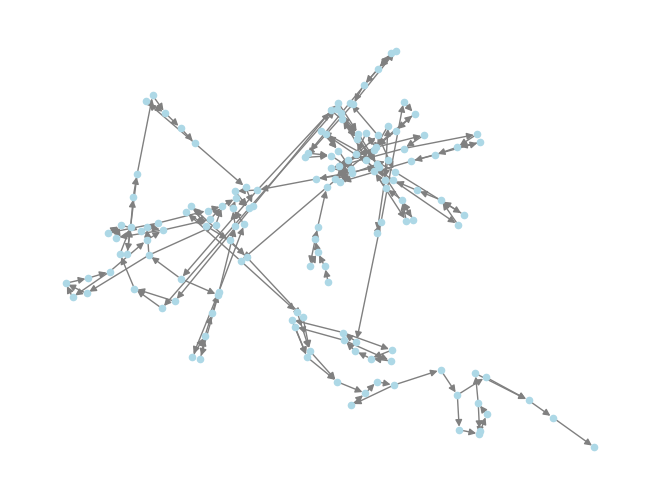

In [48]:
import networkx as nx

nx.draw(nx_model, with_labels=False, node_color='lightblue', edge_color='gray', node_size=20, font_size=15)

In [49]:
# from torch_geometric.utils import from_networkx
# 
# data = from_networkx(nx_model)

In [53]:
top_nodes = set(n for n, a in nx_model.nodes(data=True) if a['attr']['type'] == 'place')
bottom_nodes = set(nx_model) - top_nodes

In [57]:
degree_centrality = nx.bipartite.degree_centrality(nx_model, top_nodes)

In [62]:
degree_centrality[next(iter(top_nodes))]

0.03260869565217391

In [63]:
from node2vec import Node2Vec

In [68]:
n2v = Node2Vec(nx_model, dimensions=64, walk_length=30, num_walks=200, p=1, q=1, workers=1, seed=42)

Computing transition probabilities:   0%|          | 0/151 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 200/200 [00:01<00:00, 105.79it/s]


In [69]:
n2v_model = n2v.fit(window=10, min_count=1, batch_words=4)

In [70]:
[n2v_model.wv[n] for n in nx_model.nodes]

[array([ 0.40505195,  0.07123872, -0.20527525,  0.25017276, -0.19563502,
         0.11127958,  0.37822935,  0.25170943, -0.61697334,  0.01770376,
         0.76822144, -0.5632603 ,  0.64231795, -0.32186002,  1.0969458 ,
        -0.02076538,  0.47552562, -0.35524648, -0.32891932, -0.4420209 ,
         0.8026216 ,  0.15011817,  0.0977003 ,  0.0324551 ,  0.01406243,
         0.64634997, -0.4711865 , -0.3944046 ,  0.03078946, -0.07505015,
        -0.5772166 , -0.32617015,  0.06250266, -0.4252126 , -0.49886954,
         0.2941927 ,  0.3235251 ,  0.15354323,  0.31104574,  0.04231038,
        -0.2279984 ,  0.00529986, -0.18195952, -0.4315219 ,  0.5175353 ,
        -0.10440414,  0.42609316, -0.46005318,  0.23166901,  0.6798526 ,
         0.37593302, -0.35423616,  0.16003855,  0.8647755 ,  0.892766  ,
        -0.11816497, -0.5774809 ,  0.42496023, -1.0233624 ,  0.26266438,
         0.11994144,  0.33339253, -0.5892149 , -0.21981165], dtype=float32),
 array([-0.27573854,  0.65070856,  0.1647524 , 